# Предварительный анализ данных по проекту - влияние условий жизни учащихся на их успеваемость по математике

## Задача проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import scipy.stats as stat

%matplotlib inline

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
print('Pandas version', pd.__version__)
print('Seaborn version', sns.__version__)
print('Numpy version', np.__version__)

Pandas version 1.0.5
Seaborn version 0.10.0
Numpy version 1.18.5


In [3]:
# Загружаем набор
stud = pd.read_csv('stud_math.xls')
stud.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [4]:
# Удалим дублирующиеся строки (если они есть)
stud.drop_duplicates(inplace=True)

In [5]:
# Теперь можно на него посмотреть
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [6]:
# Целевая переменная содержит пропуски - эти строки можно удалить
stud.dropna(subset=['score'], inplace=True)
print(f'Кооличество пропусков в признаке score = {stud["score"].isna().sum()}')

Кооличество пропусков в признаке score = 0


In [7]:
# В задании не описан столбец 'studytime, granular', посмотрим на его корелляцию с другими признаками
stud.corr()['studytime, granular']

age                    0.018227
Medu                  -0.081032
Fedu                  -0.059618
traveltime             0.105910
studytime             -1.000000
failures               0.181947
studytime, granular    1.000000
famrel                -0.046249
freetime               0.125066
goout                  0.053831
health                 0.079180
absences               0.025707
score                 -0.115741
Name: studytime, granular, dtype: float64

In [8]:
# Видим, что признак 'studytime, granular' отрицательно коррелирован с 'studytime' - удаляем его
stud.drop('studytime, granular', axis=1, inplace=True)
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   Pstatus     344 non-null    object 
 6   Medu        386 non-null    float64
 7   Fedu        365 non-null    float64
 8   Mjob        370 non-null    object 
 9   Fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   382 non-null    float64
 14  failures    367 non-null    float64
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

In [9]:
# Из всех признаков числовыми я бы назвал только age, absences, score
# остальные номинативные
num_features = ['age', 'absences', 'score']
nom_features = list(set(stud.columns) - set(num_features))
nan_features = []

## Исследование числовых признаков

In [10]:
def describe(feature):
    display(stud[feature].describe())
    print(f'Количество пропусков: {stud[feature].isna().sum()}')
    print(
        f'Процент пропусков: {round((stud[feature].isna().sum() / len(stud[feature])) * 100, 2)}%')


def outliers(feature):
    # Интерквартильный размах
    perc25 = stud[feature].quantile(0.25)
    perc75 = stud[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return stud[(stud[feature] < low) | (stud[feature] > high)]


def hist(df, feature, bins=80):
    fig, ax = plt.subplots()
    #  Добавляем подписи к осям:
    ax.set_xlabel(feature)
    ax.set_ylabel('count')
    ax.set_title(f'Гистограмма распределения признака {feature}')
    _ = df[feature].hist(bins=bins, ax=ax)


def boxplot(feature):
    fig, ax = plt.subplots()
    ax.set_title(f'Boxplot признака {feature}')
    _ = sns.boxplot(x=stud[feature], ax=ax)
    
    
def countplot(feature):
    fig, ax = plt.subplots()
    #  Добавляем подписи к осям:
    ax.set_xlabel(feature)
    ax.set_ylabel('count')
    ax.set_title(f'Кол-во значений признака {feature}')
    sns.set_style('whitegrid')
    _ = sns.countplot(x=feature, data=stud.fillna('NaN'), ax=ax)

### score — баллы по госэкзамену по математике

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Количество пропусков: 0
Процент пропусков: 0.0%
25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0, Границы выбросов: [-5.0, 115.0]
Выбросы не обнаружены


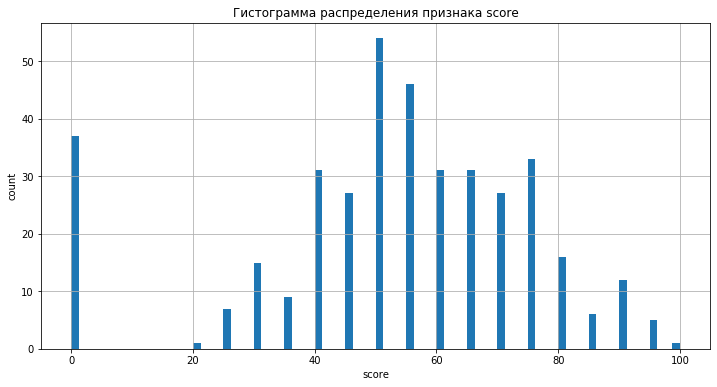

In [11]:
describe('score')
hist(stud, 'score')

out_df = outliers('score')
if not out_df.empty:
    print('Обнаружены выбросы:')
    display(out_df)
else:
    print('Выбросы не обнаружены')

In [12]:
# Очень много значений score = 0
print(f'Количество score равных 0: {len(stud[stud["score"] == 0])}')
print(
    f'Процент score равных 0: {round(len(stud[stud["score"] == 0]) * 100 / len(stud), 2)}')
stud[stud["score"] == 0]

Количество score равных 0: 37
Процент score равных 0: 9.51


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,course,father,2.0,3.0,2.0,no,yes,no,no,yes,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,course,mother,NaN,2.0,0.0,no,yes,no,no,yes,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,NaN,course,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,no,no,NaN,no,yes,yes,no,no,NaN,4.0,5.0,5.0,0.0,0.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,no,yes,no,no,yes,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,home,father,1.0,2.0,3.0,no,NaN,no,no,yes,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


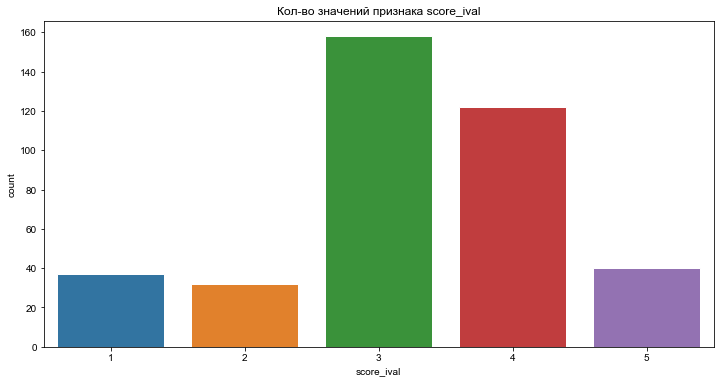

In [13]:
# Такой большой процент при условии, что нет студентов с результатом меньше 20 баллов не равных 0, говорит, скорее всего, о том,
# что при результате экзамена меньше 20 баллов ставится 0.  Если это так, то предполагаю 5 возможных сценария обработки этих данных
# 1 - оставить все как есть (алгоритм ML может настроится на 0)
# 2 - удалить эти данные из рассмотрения (но в задании говорится о выявлении группы риска, а это она и есть)
# 3 - заполнить параметр score, как нормально распределенные величины из диапазона 0 - 15  с шагом 5
# 4 - разделить результирующую переменную на интервалы [0,20[, [20,40[, [40,60[, [60,80[, [80,100], 
# 5 - выделить бинарный признак, относится ли ученик к группе риска [0,20[ = 1, [20,100] = 0, 
stud['score_ival'] = stud['score'].map(
    lambda x: 1 if x >= 0 and x < 20 else 2 if x >= 20 and x < 40 else 3 
                if x >= 40 and x < 60 else 4 if x >= 60 and x < 80 else 5)
countplot('score_ival')

### absences — количество пропущенных занятий

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Количество пропусков: 11
Процент пропусков: 2.83%
25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0, Границы выбросов: [-12.0, 20.0]
Обнаружены выбросы (17):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,score_ival
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0,5
313,GP,F,19,U,NaN,NaN,3.0,2.0,services,other,reputation,other,2.0,2.0,NaN,no,NaN,NaN,no,no,yes,yes,yes,4.0,2.0,2.0,1.0,22.0,55.0,3
277,GP,M,18,U,GT3,T,4.0,4.0,NaN,services,home,mother,2.0,1.0,0.0,no,no,yes,yes,yes,yes,yes,no,3.0,2.0,4.0,3.0,22.0,45.0,3
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0,2
320,GP,F,17,U,GT3,A,4.0,3.0,services,services,course,mother,1.0,2.0,NaN,no,yes,yes,no,yes,NaN,yes,yes,5.0,2.0,2.0,5.0,23.0,65.0,4
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0,5
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0,3
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0,2
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0,3
280,GP,M,17,U,NaN,A,4.0,NaN,services,other,home,mother,2.0,1.0,NaN,no,no,yes,yes,yes,yes,yes,NaN,4.0,NaN,4.0,5.0,30.0,40.0,3


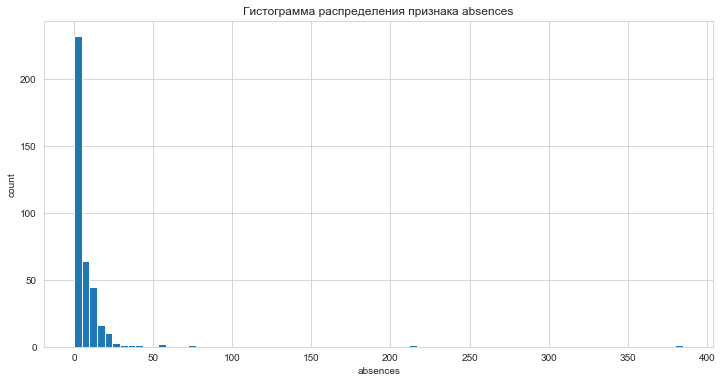

In [14]:
describe('absences')
hist(stud, 'absences')
out_df = outliers('absences')
if not out_df.empty:
    print(f'Обнаружены выбросы ({len(out_df)}):')
    display(out_df.sort_values('absences'))
else:
    print('Выбросы не обнаружены')

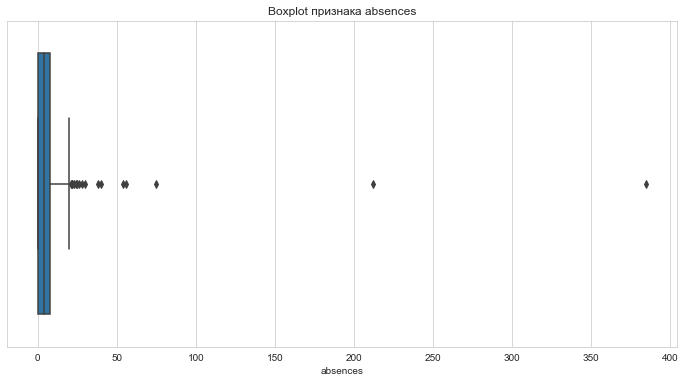

In [15]:
boxplot('absences')

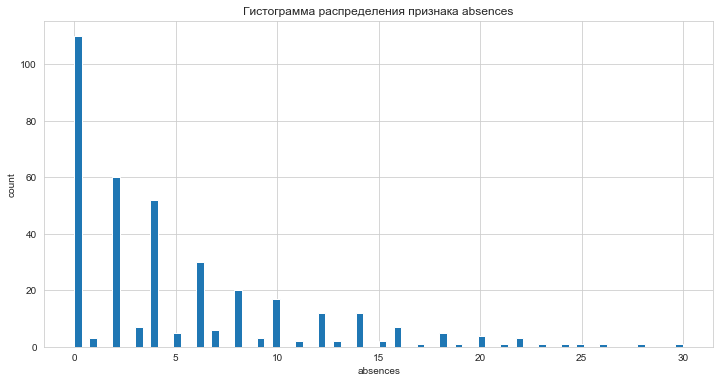

In [16]:
# Формула интерквартильного расстояния дает слишком много выбросов
# Подозрение вызывают только записи, где absences >= 30.
# С другой стороны эти студенты получили достаточно низкие баллы,
# а у студента с количеством пропусков 385 отец-учитель, и он мог находиться на домашнем обучении
stud = stud[stud['absences'].between(0, 30)]
hist(stud, 'absences')

In [17]:
# Пропуски, в данном случае, можно заполнить медианным значением
stud['absences_nan'] = stud['absences'].map(lambda x: 0 if pd.isna(x) else 1)
stud['absences'].fillna(stud['absences'].median(), inplace=True)
nan_features.append('absences_nan')
stud['absences'].describe()

count    371.000000
mean       5.140162
std        5.884637
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       30.000000
Name: absences, dtype: float64

### age — возраст ученика (от 15 до 22)

count    371.000000
mean      16.649596
std        1.256816
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Количество пропусков: 0
Процент пропусков: 0.0%
25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0, Границы выбросов: [13.0, 21.0]
Обнаружены выбросы (1):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,score_ival,absences_nan
247,GP,M,22,U,GT3,T,3.0,1.0,services,services,other,mother,1.0,1.0,3.0,no,no,no,no,no,no,yes,yes,5.0,4.0,5.0,1.0,16.0,40.0,3,1


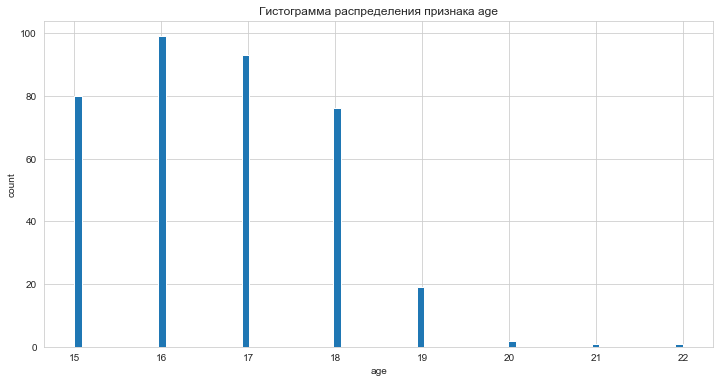

In [18]:
describe('age')
hist(stud, 'age')
out_df = outliers('age')
if not out_df.empty:
    print(f'Обнаружены выбросы ({len(out_df)}):')
    display(out_df.sort_values('age'))
else:
    print('Выбросы не обнаружены')

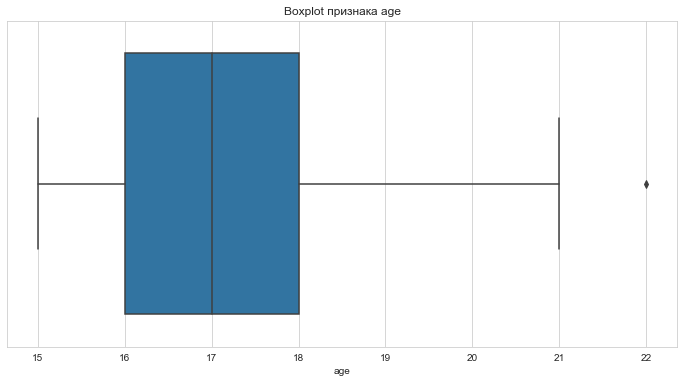

In [19]:
boxplot('age')

In [20]:
# Студенты старше 21 года определяются как выбросы, но в задании указан интервал от 15 до 22 лет.
# Ученик в возрасте 22 года - это, судя по всему, какой-то отдельный случай (скорее всего влияет здоровье - 1)

## Исследование номинативных признаков

In [21]:
# Теперь возможные значения
for feature in nom_features:
    print(f'Уникальные значения признака {feature}:', np.sort(
        stud[feature].dropna().unique()))

Уникальные значения признака Fedu: [ 0.  1.  2.  3.  4. 40.]
Уникальные значения признака Mjob: ['at_home' 'health' 'other' 'services' 'teacher']
Уникальные значения признака Fjob: ['at_home' 'health' 'other' 'services' 'teacher']
Уникальные значения признака school: ['GP' 'MS']
Уникальные значения признака Pstatus: ['A' 'T']
Уникальные значения признака traveltime: [1. 2. 3. 4.]
Уникальные значения признака reason: ['course' 'home' 'other' 'reputation']
Уникальные значения признака health: [1. 2. 3. 4. 5.]
Уникальные значения признака studytime: [1. 2. 3. 4.]
Уникальные значения признака failures: [0. 1. 2. 3.]
Уникальные значения признака internet: ['no' 'yes']
Уникальные значения признака sex: ['F' 'M']
Уникальные значения признака activities: ['no' 'yes']
Уникальные значения признака paid: ['no' 'yes']
Уникальные значения признака higher: ['no' 'yes']
Уникальные значения признака romantic: ['no' 'yes']
Уникальные значения признака guardian: ['father' 'mother' 'other']
Уникальные зн

In [22]:
# Для удобства рассмотрения предлагаю разделить номинативные признаки на 3 группы:
# 1 - принимающие 2 значения (бинарные)
# 2 - те, что имеют отношения порядка (порядковые)
# 3 - где нет отношения порядка (категориальные)
bin_features = ['nursery', 'Pstatus', 'schoolsup', 'higher', 'paid', 'famsup',
                'romantic', 'address', 'sex', 'activities', 'school', 'famsize']
cat_features = ['guardian', 'Fjob', 'Mjob', 'reason']
ord_features = ['health', 'famrel', 'studytime', 'traveltime',
                'Fedu', 'Medu', 'freetime', 'failures', 'goout']

 ###  Бинарные признаки

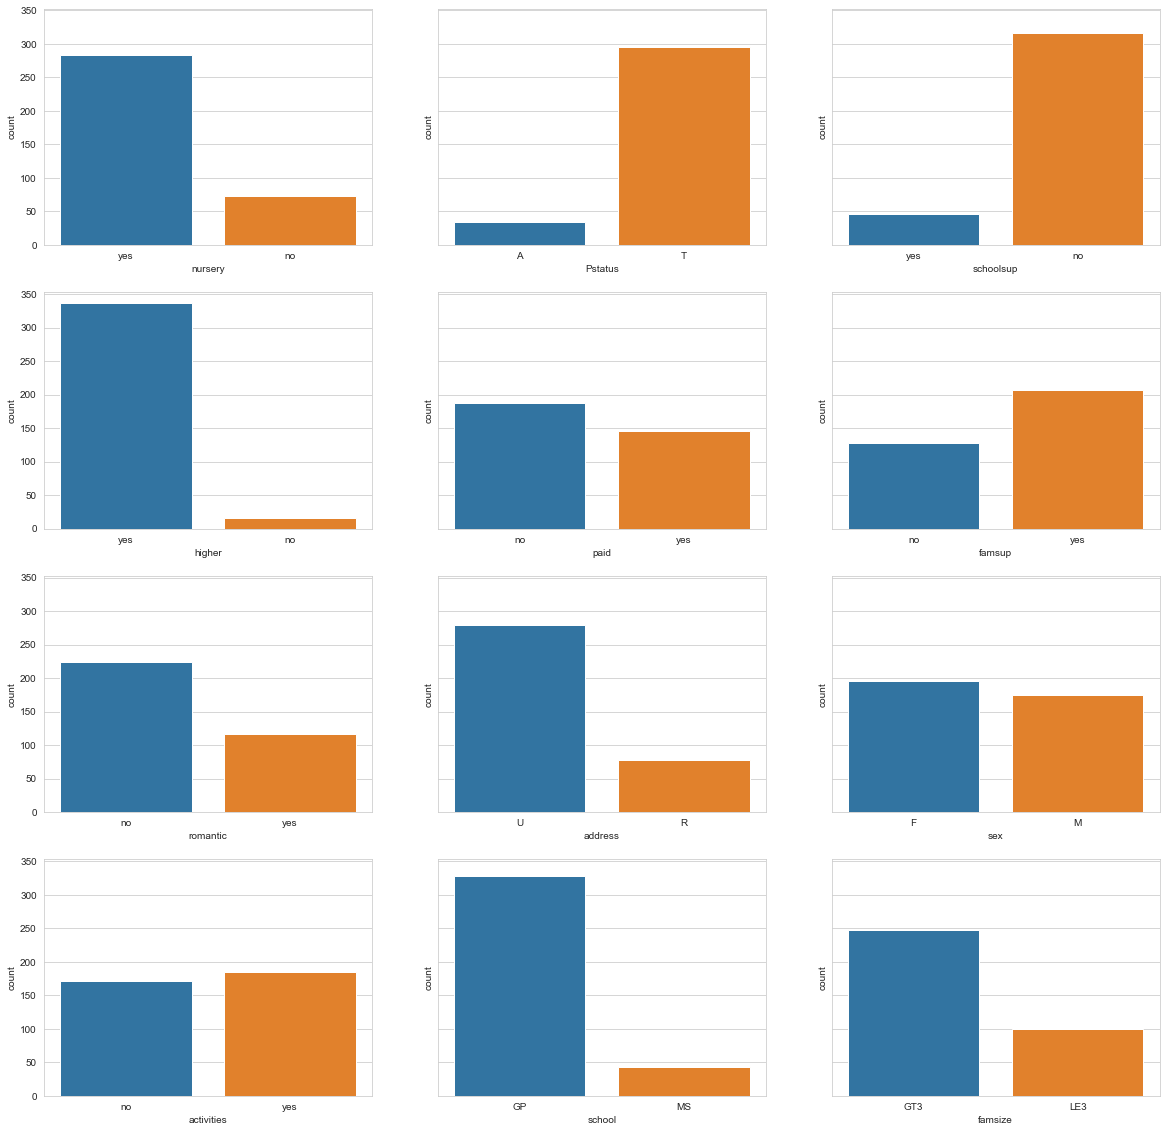

In [23]:
# Ищем выбросы
fig, axes = plt.subplots(
    int(np.ceil(len(bin_features) / 3)), 3, figsize=(20, 20), sharey=True)
for i in range(len(bin_features)):
    sns.set_style('whitegrid')
    sns.countplot(x=bin_features[i], data=stud, ax=axes[int(i / 3), i % 3])

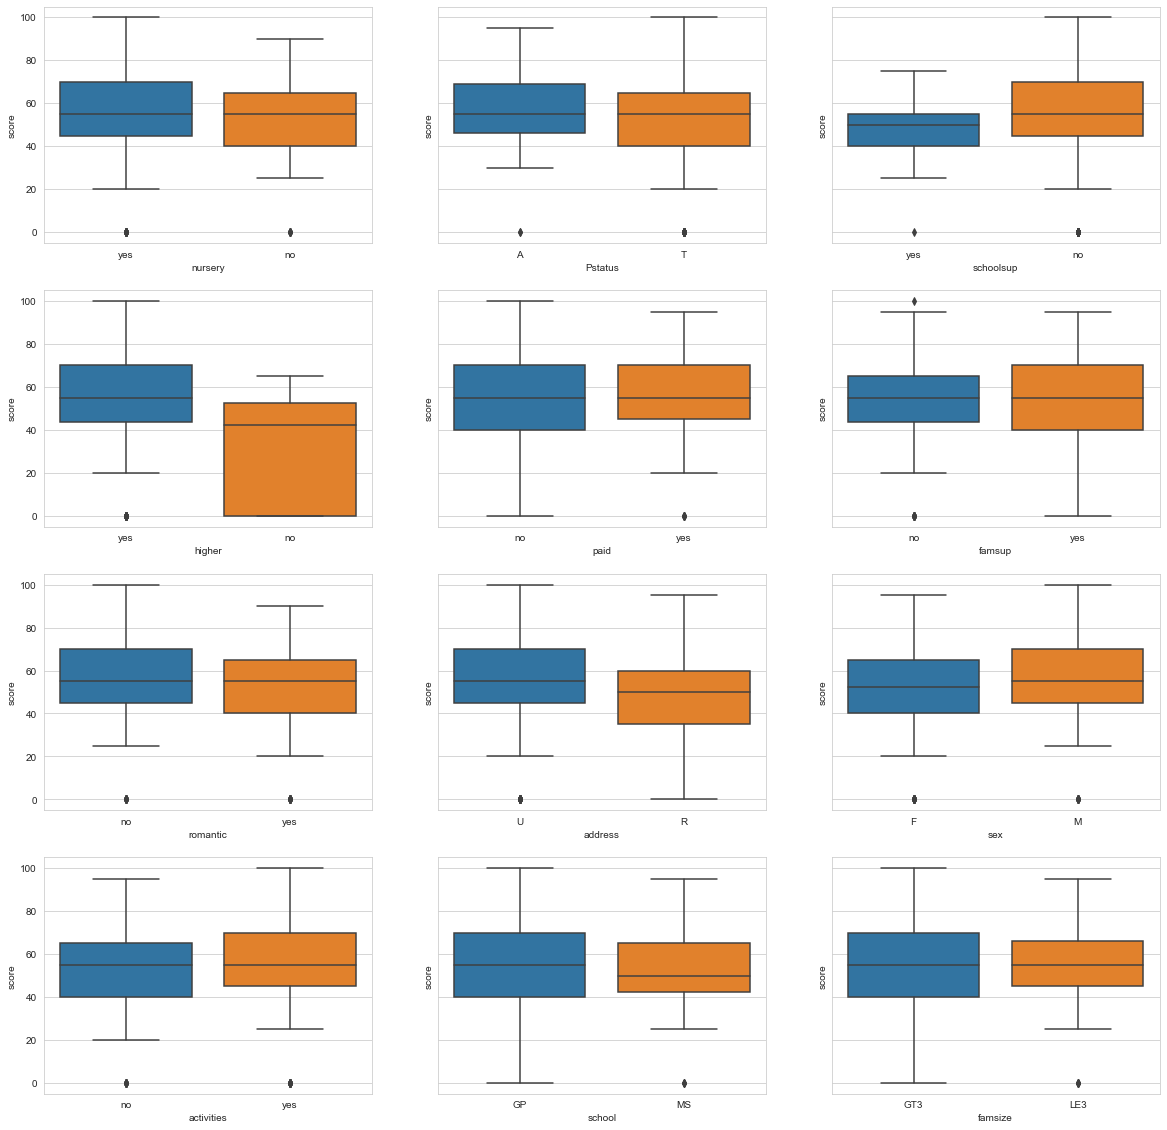

In [24]:
# Все признаки принимают 2 значения (можно потом закодировать 0 и 1). Выбросов нет.
# Имеется сильная несбалансированность по некоторым из них (higher, Pstatus, school), но пока рано делать какие-то выводы
fig, axes = plt.subplots(
    int(np.ceil(len(bin_features) / 3)), 3, figsize=(20, 20), sharey=True)
for i in range(len(bin_features)):
    sns.boxplot(x=bin_features[i], y='score', data=stud, ax=axes[int(i / 3), i % 3])

In [25]:
# Кажется признак higher имеет влияние на целевую переменную надо оставлять, Pstatus  и school - нет (можно будет удалить)

In [26]:
# Посмотрим на количество пропусков в этих столбцах
for feature in bin_features:
    nan_count = stud[feature].isna().sum()
    print(
        f'Количество пропусков в столбце {feature} - {nan_count} ({round(nan_count * 100 / len(stud), 2)}%)')

Количество пропусков в столбце nursery - 15 (4.04%)
Количество пропусков в столбце Pstatus - 41 (11.05%)
Количество пропусков в столбце schoolsup - 9 (2.43%)
Количество пропусков в столбце higher - 19 (5.12%)
Количество пропусков в столбце paid - 38 (10.24%)
Количество пропусков в столбце famsup - 36 (9.7%)
Количество пропусков в столбце romantic - 31 (8.36%)
Количество пропусков в столбце address - 14 (3.77%)
Количество пропусков в столбце sex - 0 (0.0%)
Количество пропусков в столбце activities - 14 (3.77%)
Количество пропусков в столбце school - 0 (0.0%)
Количество пропусков в столбце famsize - 24 (6.47%)


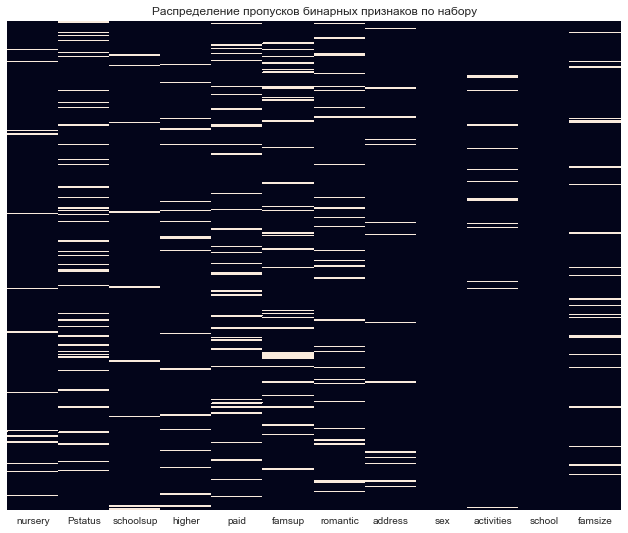

In [27]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Распределение пропусков бинарных признаков по набору')
_ = sns.heatmap(stud[bin_features].isnull(),
                cbar=False, ax=ax, yticklabels=False)

In [28]:
# Признаки содержат достаточно много пропусков.
# Заполним пропущенные значения модой и чтобы не потерять информацию о пропусках добавим признак с суффиксои _nan, 
# где 0 - пропуск, 1 - нет
for feature in bin_features:
    stud[feature + '_nan'] = stud[feature].map(lambda x: 1 if pd.isna(x) else 0)
    nan_features.append(feature + '_nan')
    stud[feature].fillna(stud[feature].mode()[0], inplace=True)
stud[bin_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 0 to 394
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   nursery     371 non-null    object
 1   Pstatus     371 non-null    object
 2   schoolsup   371 non-null    object
 3   higher      371 non-null    object
 4   paid        371 non-null    object
 5   famsup      371 non-null    object
 6   romantic    371 non-null    object
 7   address     371 non-null    object
 8   sex         371 non-null    object
 9   activities  371 non-null    object
 10  school      371 non-null    object
 11  famsize     371 non-null    object
dtypes: object(12)
memory usage: 47.7+ KB


### Категориальные признаки

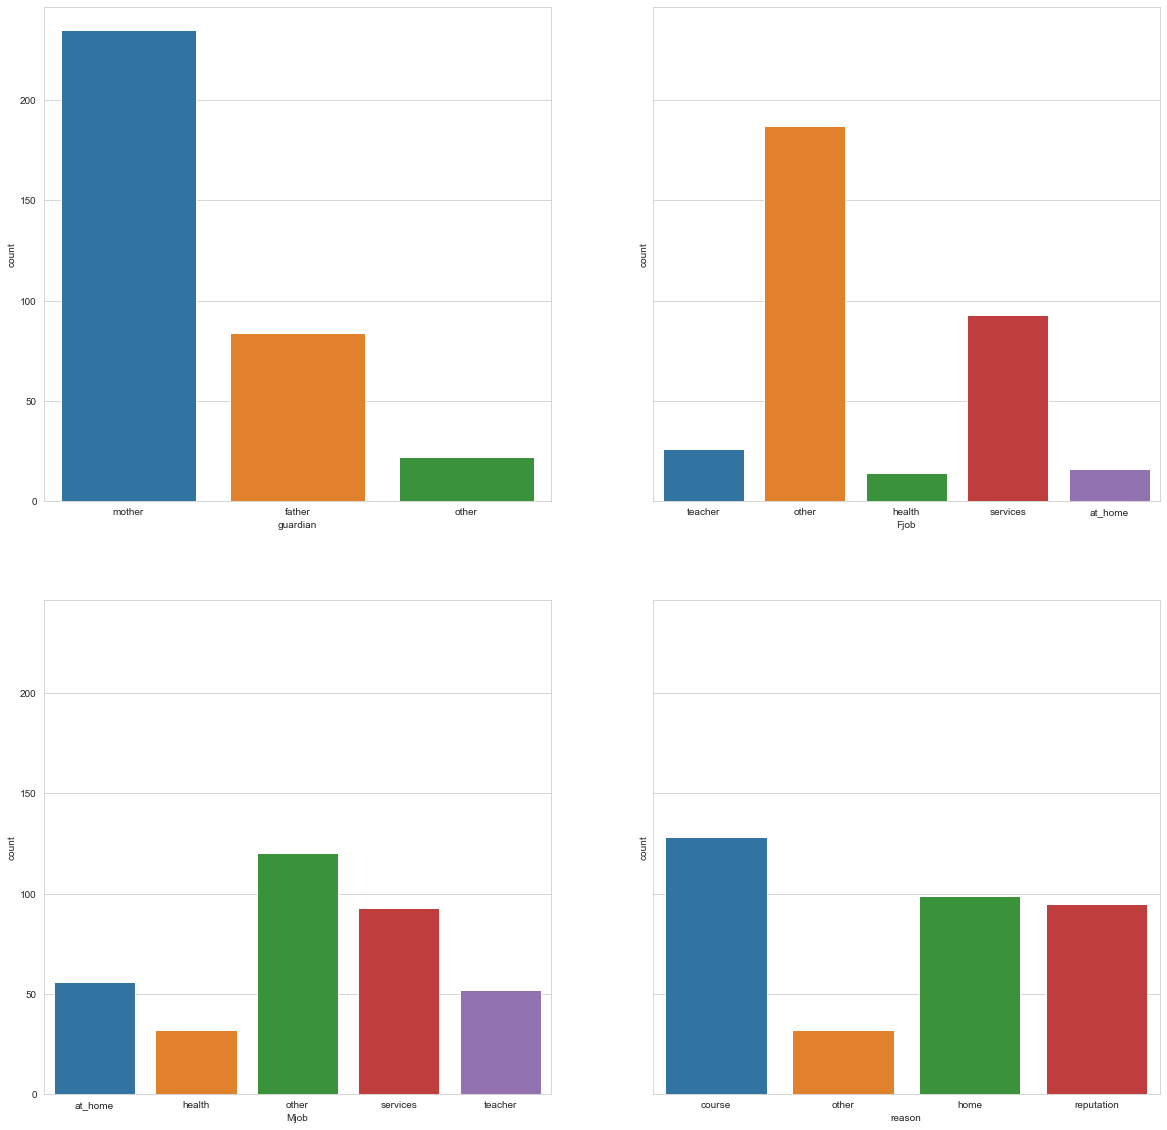

In [29]:
# Ищем выбросы
fig, axes = plt.subplots(
    int(np.ceil(len(cat_features) / 2)), 2, figsize=(20, 20), sharey=True)
for i in range(len(cat_features)):
    sns.set_style('whitegrid')
    sns.countplot(x=cat_features[i], data=stud, ax=axes[int(i / 2), i % 2])

In [30]:
# Все признаки принимают значения, соответствующие заданию. Выбросов нет.
# Можно закодировать, например one-hot

In [31]:
# Посмотрим на количество пропусков в этих столбцах
for feature in cat_features:
    nan_count = stud[feature].isna().sum()
    print(
        f'Количество пропусков в столбце {feature} - {nan_count} ({round(nan_count * 100 / len(stud), 2)}%)')

Количество пропусков в столбце guardian - 30 (8.09%)
Количество пропусков в столбце Fjob - 35 (9.43%)
Количество пропусков в столбце Mjob - 18 (4.85%)
Количество пропусков в столбце reason - 17 (4.58%)


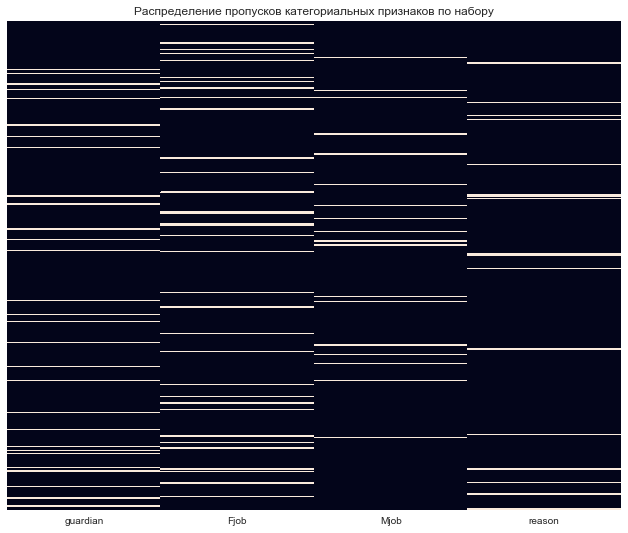

In [32]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Распределение пропусков категориальных признаков по набору')
_ = sns.heatmap(stud[cat_features].isnull(),
                cbar=False, ax=ax, yticklabels=False)

In [33]:
# Признаки содержат достаточно много пропусков.
# Заполним пропущенные значения модой и чтобы не потерять информацию о пропусках добавим признак с суффиксои _nan, 
# где 0 - пропуск, 1 - нет
for feature in cat_features:
    stud[feature + '_nan'] = stud[feature].map(lambda x: 1 if pd.isna(x) else 0)
    nan_features.append(feature + '_nan')
    stud[feature].fillna(stud[feature].mode()[0], inplace=True)
stud[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 0 to 394
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  371 non-null    object
 1   Fjob      371 non-null    object
 2   Mjob      371 non-null    object
 3   reason    371 non-null    object
dtypes: object(4)
memory usage: 24.5+ KB


### Порядковые признаки

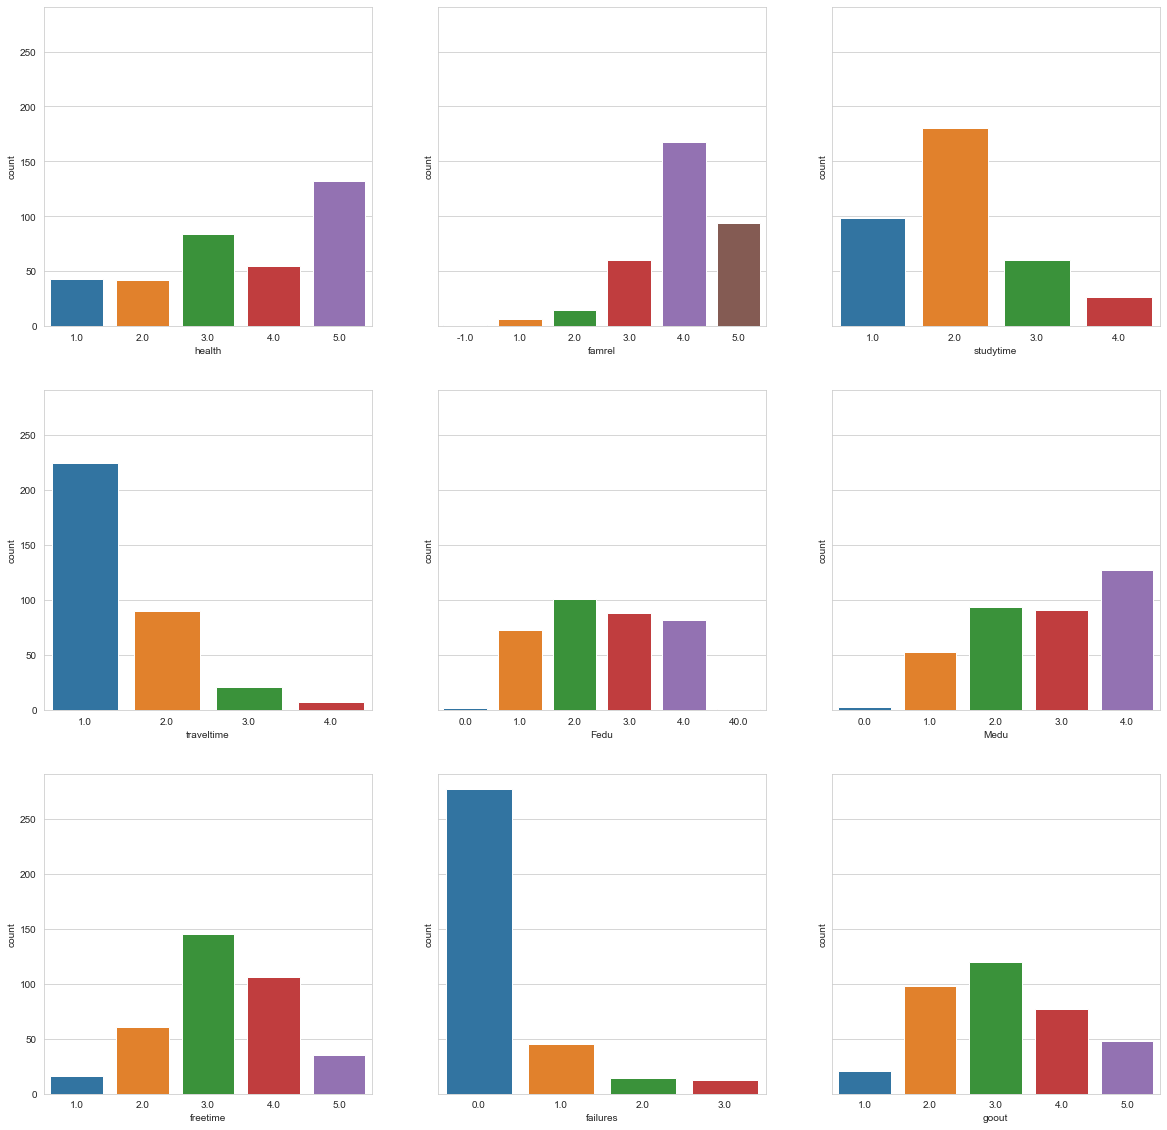

In [34]:
# Ищем выбросы
fig, axes = plt.subplots(
    int(np.ceil(len(ord_features) / 3)), 3, figsize=(20, 20), sharey=True)
for i in range(len(ord_features)):
    sns.set_style('whitegrid')
    sns.countplot(x=ord_features[i], data=stud, ax=axes[int(i / 3), i % 3])

In [35]:
# Видны значения, не соответствующие описанию признаков в задании.
# В признаке famrel - значение -1
display(stud[stud['famrel'] == -1])
# В признаке Fedu - значение 40
display(stud[stud['Fedu'] == 40])

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,score_ival,absences_nan,nursery_nan,Pstatus_nan,schoolsup_nan,higher_nan,paid_nan,famsup_nan,romantic_nan,address_nan,sex_nan,activities_nan,school_nan,famsize_nan,guardian_nan,Fjob_nan,Mjob_nan,reason_nan
25,GP,F,16,U,GT3,T,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,score_ival,absences_nan,nursery_nan,Pstatus_nan,schoolsup_nan,higher_nan,paid_nan,famsup_nan,romantic_nan,address_nan,sex_nan,activities_nan,school_nan,famsize_nan,guardian_nan,Fjob_nan,Mjob_nan,reason_nan
11,GP,F,15,U,GT3,T,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0,4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
# Скорее всего в Fedu 40 записано вместо 4, а в famrel -1 вместо 1, но точно сказать нельзя. Эти записи удаляем.
stud = stud[stud['Fedu'] != 40]
stud = stud[stud['famrel'] != -1]

In [37]:
# Посмотрим на количество пропусков в этих столбцах
for feature in ord_features:
    nan_count = stud[feature].isna().sum()
    print(
        f'Количество пропусков в столбце {feature} - {nan_count} ({round(nan_count * 100 / len(stud), 2)}%)')

Количество пропусков в столбце health - 15 (4.07%)
Количество пропусков в столбце famrel - 26 (7.05%)
Количество пропусков в столбце studytime - 5 (1.36%)
Количество пропусков в столбце traveltime - 28 (7.59%)
Количество пропусков в столбце Fedu - 24 (6.5%)
Количество пропусков в столбце Medu - 3 (0.81%)
Количество пропусков в столбце freetime - 8 (2.17%)
Количество пропусков в столбце failures - 22 (5.96%)
Количество пропусков в столбце goout - 7 (1.9%)


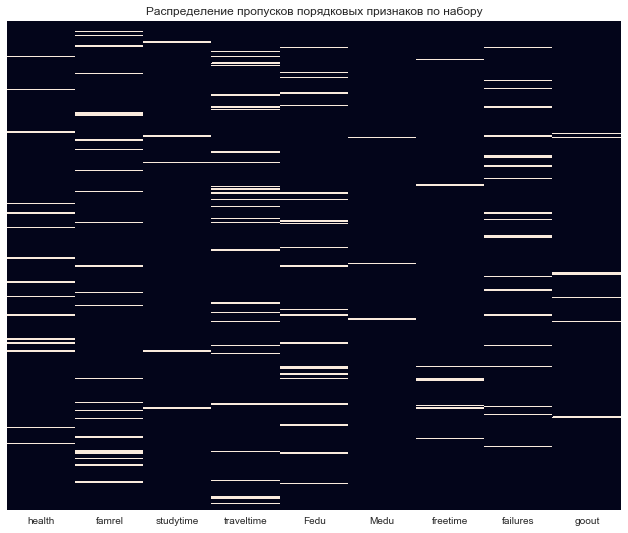

In [38]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Распределение пропусков порядковых признаков по набору')
_ = sns.heatmap(stud[ord_features].isnull(),
                cbar=False, ax=ax, yticklabels=False)

In [39]:
# Признаки содержат отнсительно немного пропусков.
# Заполним пропущенные значения модой и чтобы не потерять информацию о пропусках добавим признак с суффиксои _nan, 
# где 0 - пропуск, 1 - нет
for feature in ord_features:
    stud[feature + '_nan'] = stud[feature].map(lambda x: 1 if pd.isna(x) else 0)
    nan_features.append(feature + '_nan')
    stud[feature].fillna(stud[feature].mode()[0], inplace=True)

## Корреляционный анализ количественных переменных

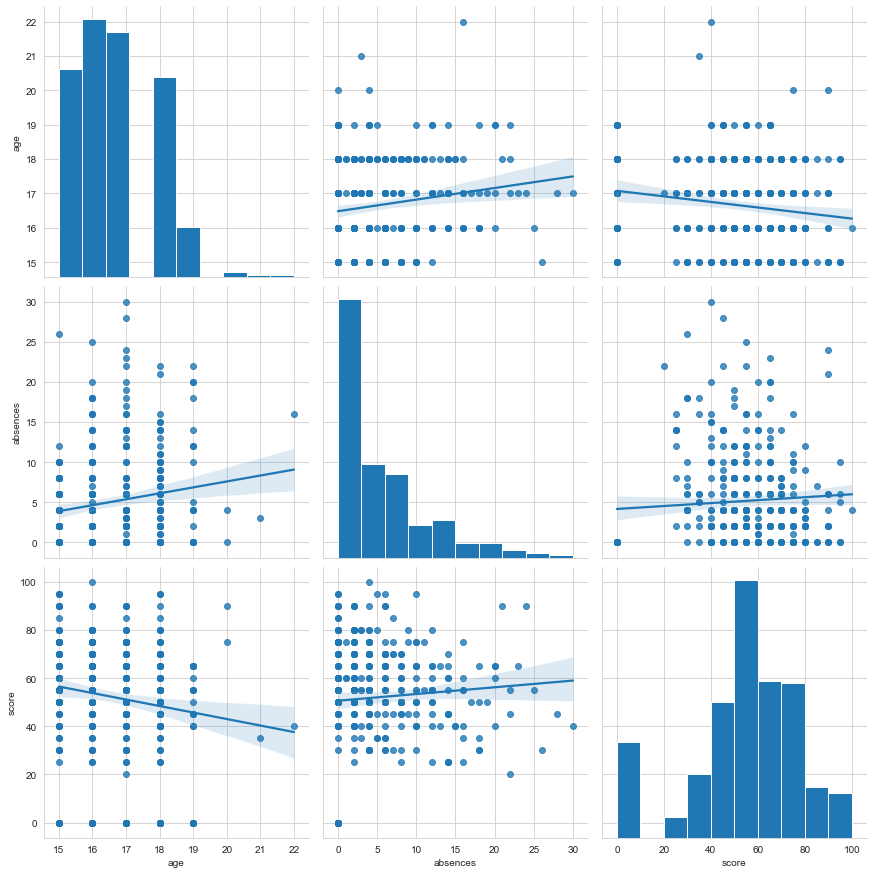

In [40]:
_ = sns.pairplot(stud[num_features], kind='reg', height=4)

In [41]:
stud[num_features].corr()

,age,absences,score
age,1.000000,0.158109,-0.147732
absences,0.158109,1.000000,0.071467
score,-0.147732,0.071467,1.000000


In [42]:
# Видна незначительная корреляция между признаками age и absences

## Корреляционный анализ номинативных переменных

In [43]:
# Для проверки корреляции между номинативными переменными создадим
# новый набор данных и закодируем значения этих переменных
stud_model = stud.copy()
stud_model

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,...,nursery_nan,Pstatus_nan,schoolsup_nan,higher_nan,paid_nan,famsup_nan,romantic_nan,address_nan,sex_nan,activities_nan,school_nan,famsize_nan,guardian_nan,Fjob_nan,Mjob_nan,reason_nan,health_nan,famrel_nan,studytime_nan,traveltime_nan,Fedu_nan,Medu_nan,freetime_nan,failures_nan,goout_nan
0,GP,F,18,U,GT3,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,GP,F,17,U,GT3,T,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,no,no,yes,yes,yes,no,4.0,3.0,...,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,GP,F,15,U,GT3,T,4.0,2.0,health,other,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,MS,F,18,U,GT3,T,1.0,1.0,other,other,course,mother,1.0,2.0,1.0,no,no,no,yes,yes,yes,NaN,no,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,yes,yes,no,2.0,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,mother,1.0,1.0,3.0,no,no,no,no,no,yes,no,no,5.0,5.0,...,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,yes,no,yes,yes,no,4.0,4.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
stud_model['school'] = stud_model['school'].apply(
    lambda x: 1 if x == 'GP' else 0 if x == 'MS' else x)
stud_model['sex'] = stud_model['sex'].apply(
    lambda x: 1 if x == 'M' else 0 if x == 'F' else x)
stud_model['address'] = stud_model['address'].apply(
    lambda x: 1 if x == 'U' else 0 if x == 'R' else x)
stud_model['famsize'] = stud_model['famsize'].apply(
    lambda x: 1 if x == 'GT3' else 0 if x == 'LE3' else x)
stud_model['Pstatus'] = stud_model['Pstatus'].apply(
    lambda x: 1 if x == 'A' else 0 if x == 'T' else x)

stud_model['schoolsup'] = stud_model['schoolsup'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['famsup'] = stud_model['famsup'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['paid'] = stud_model['paid'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['activities'] = stud_model['activities'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['nursery'] = stud_model['nursery'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['higher'] = stud_model['higher'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['internet'] = stud_model['internet'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
stud_model['romantic'] = stud_model['romantic'].apply(
    lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)

#stud_model = pd.get_dummies(stud_model, columns=cat_features)

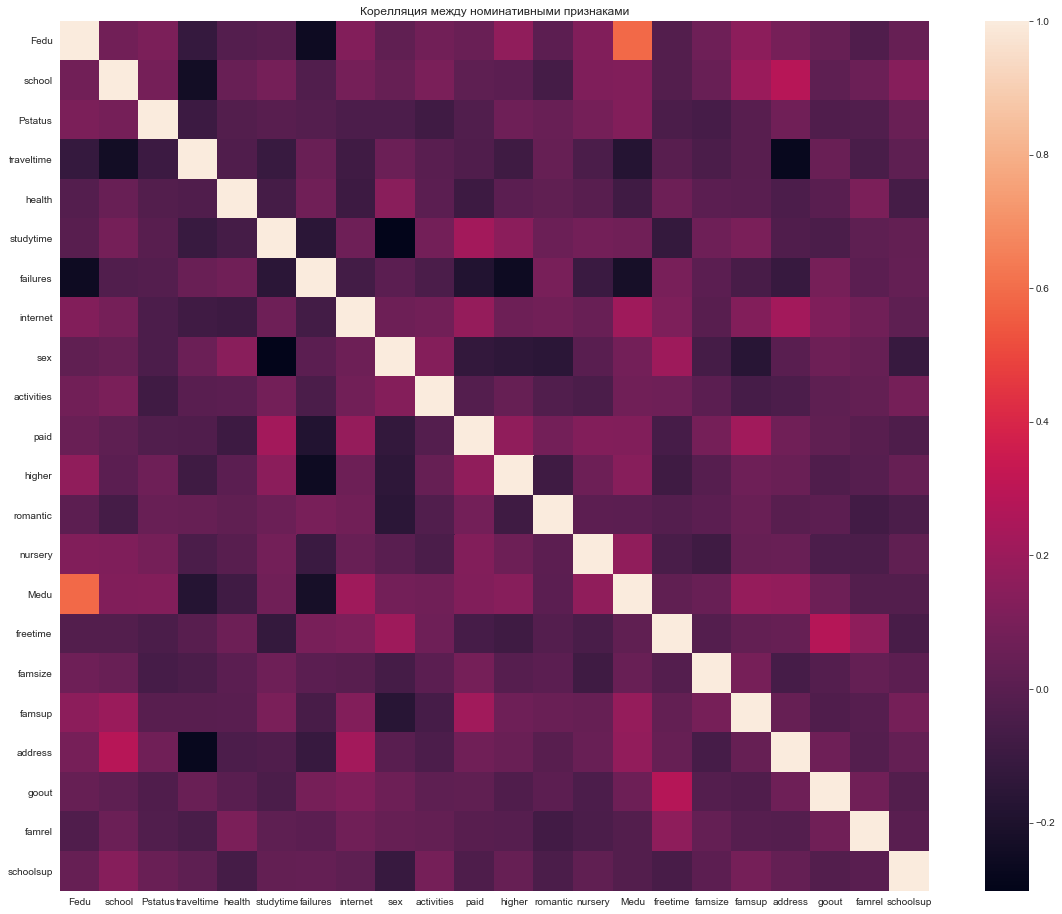

In [45]:
fig, ax = plt.subplots(figsize=(20, 16))
ax.set_title('Корелляция между номинативными признаками')
_ = sns.heatmap(stud_model[nom_features].corr(), ax=ax, square=True)

In [46]:
stud_model[nom_features].corr().style.applymap(lambda x: 'color: red' if abs(x) > 0.5 else '')

,Fedu,school,Pstatus,traveltime,health,studytime,failures,internet,sex,activities,paid,higher,romantic,nursery,Medu,freetime,famsize,famsup,address,goout,famrel,schoolsup
Fedu,1.000000,0.074898,0.105050,-0.118739,-0.015328,-0.006389,-0.256181,0.126190,0.020523,0.077462,0.050914,0.170695,0.010947,0.123609,0.593018,-0.021853,0.065767,0.159669,0.093945,0.042838,-0.031003,0.040153
school,0.074898,1.000000,0.086500,-0.240599,0.044668,0.087288,-0.026294,0.089368,0.040476,0.102865,0.013514,0.005619,-0.063354,0.119559,0.123276,-0.018182,0.044596,0.196683,0.287763,0.015975,0.057735,0.137058
Pstatus,0.105050,0.086500,1.000000,-0.095098,-0.020659,-0.004230,-0.015183,-0.038648,-0.039869,-0.079744,-0.024362,0.067825,0.046655,0.085926,0.128805,-0.046527,-0.058729,-0.004055,0.073139,-0.027495,-0.025408,0.049966
traveltime,-0.118739,-0.240599,-0.095098,1.000000,-0.031854,-0.108754,0.051019,-0.080785,0.058861,-0.000195,-0.032027,-0.086979,0.038830,-0.045544,-0.172067,-0.003202,-0.045459,-0.005187,-0.273636,0.049514,-0.048998,0.014166
health,-0.015328,0.044668,-0.020659,-0.031854,1.000000,-0.063717,0.071859,-0.092760,0.149689,0.007859,-0.091562,0.004302,0.018633,-0.002264,-0.081990,0.063225,0.004697,-0.001543,-0.042285,0.000568,0.109030,-0.065493
studytime,-0.006389,0.087288,-0.004230,-0.108754,-0.063717,1.000000,-0.152920,0.066854,-0.302078,0.083152,0.224110,0.151701,0.057131,0.080197,0.070354,-0.123230,0.065296,0.102262,-0.030027,-0.044929,0.017544,0.030337
failures,-0.256181,-0.026294,-0.015183,0.051019,0.071859,-0.152920,1.000000,-0.069002,0.006443,-0.046720,-0.181759,-0.251216,0.095127,-0.102820,-0.225557,0.098006,0.007050,-0.055596,-0.111274,0.089964,0.006117,0.038484
internet,0.126190,0.089368,-0.038648,-0.080785,-0.092760,0.066854,-0.069002,1.000000,0.063572,0.074802,0.181689,0.062362,0.078203,0.045272,0.215595,0.114025,-0.005575,0.126434,0.225705,0.115380,0.071191,0.014590
sex,0.020523,0.040476,-0.039869,0.058861,0.149689,-0.302078,0.006443,0.063572,1.000000,0.131666,-0.125641,-0.144215,-0.152129,0.002004,0.081638,0.210197,-0.068067,-0.163001,-0.000108,0.061241,0.041085,-0.111979
activities,0.077462,0.102865,-0.079744,-0.000195,0.007859,0.083152,-0.046720,0.074802,0.131666,1.000000,-0.014130,0.042304,-0.026267,-0.046158,0.070858,0.069197,0.008052,-0.060709,-0.041880,0.015921,0.029320,0.087476


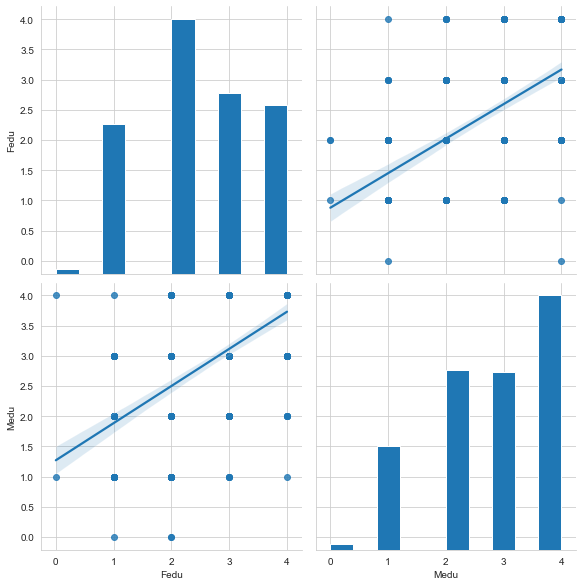

In [47]:
# Видна средняя корреляция между образованием отца (Fedu) и образованием матери (Medu)
_ = sns.pairplot(stud_model[['Fedu', 'Medu']], kind='reg', height=4)

In [48]:
# Находим наиболее частый Medu для соответствующего Fedu и заменяем
for val in stud_model[stud_model['Medu_nan'] == 1].Fedu:
    most_Medu = stud_model[stud_model.Fedu == val].Medu.value_counts().index[0]
    stud_model.loc[(stud_model['Medu_nan'] == 1) & (stud_model['Fedu'] == val)] = most_Medu

## Анализ влияния номинативных переменных на предсказываемую величину

In [49]:
def get_stat_dif(feature, dropna=True, check=True):
    cols = stud.loc[:, feature].value_counts(dropna=dropna).index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        len0 = len(stud.loc[stud.loc[:, feature] == comb[0]])
        len1 = len(stud.loc[stud.loc[:, feature] == comb[1]])
        if check and len(stud.loc[stud.loc[:, feature] == comb[0]]) < 30:
            msg = 'Количество значений {} ({}) = {} (<30) тест стьюдента может дать некорректные результаты'.format(
                feature, comb[0], len0)
            raise Exception(msg)
        if check and len(stud.loc[stud.loc[:, feature] == comb[1]]) < 30:
            msg = 'Количество значений {} ({}) = {} (<30) тест стьюдента может дать некорректные результаты'.format(
                feature, comb[1], len1)
            raise Exception(msg)
        res = ttest_ind(stud.loc[stud.loc[:, feature] == comb[0], 'score_ival'],
                        stud.loc[stud.loc[:, feature] == comb[1], 'score_ival'])
        if res.pvalue <= 0.05 / len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', feature, comb)
            return True
    return False


def get_boxplot(feature):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=feature, y='score',
                data=stud.loc[stud.loc[:, feature].isin(
                    stud.loc[:, feature].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + feature)
    plt.show()

In [50]:
# Перед проверкой признаков на влияние на результирующую переменную проверим ее на нормальность
print('P-value на score = ', stat.normaltest(stud['score']).pvalue)
print("Тест Шапиро-Уилка на нормальность распределения для первого варианта, W-statistic: %f, p-value: %.20f" %
      stat.shapiro(stud['score']))

print('P-value на score_ival = ', stat.normaltest(stud['score_ival']).pvalue)
print("Тест Шапиро-Уилка на нормальность распределения для второго варианта, W-statistic: %f, p-value: %.20f" %
      stat.shapiro(stud['score_ival']))

P-value на score =  1.8595995395176735e-07
Тест Шапиро-Уилка на нормальность распределения для первого варианта, W-statistic: 0.926942, p-value: 0.00000000000190871863
P-value на score_ival =  0.0015873113288157417
Тест Шапиро-Уилка на нормальность распределения для второго варианта, W-statistic: 0.885033, p-value: 0.00000000000000053490


In [51]:
# В обоих случаях гиротеза о нормальности отвергается, поэтому перед выполнением теста стьюдента будем проверять размер выборки

In [52]:
# Отбоор признаков, влияющих на score, если не учитывать пропуски и проверять на применимость теста стьюдента
impotant_features = []
not_tested_features = []
for feature in nom_features:
    try:
        if get_stat_dif(feature, dropna=True, check=True) == True:
            impotant_features.append(feature)
    except Exception as e:
        print('Error:', e)
        not_tested_features.append(feature)
        
print('Important:', impotant_features)
print('Not tested', not_tested_features)

Error: Количество значений Fedu (0.0) = 2 (<30) тест стьюдента может дать некорректные результаты
Найдены статистически значимые различия для колонки Mjob ('at_home', 'health')
Error: Количество значений Fjob (teacher) = 26 (<30) тест стьюдента может дать некорректные результаты
Error: Количество значений traveltime (3.0) = 20 (<30) тест стьюдента может дать некорректные результаты
Error: Количество значений studytime (4.0) = 27 (<30) тест стьюдента может дать некорректные результаты
Найдены статистически значимые различия для колонки failures (0.0, 1.0)
Найдены статистически значимые различия для колонки sex ('F', 'M')
Error: Количество значений higher (no) = 16 (<30) тест стьюдента может дать некорректные результаты
Error: Количество значений guardian (other) = 22 (<30) тест стьюдента может дать некорректные результаты
Найдены статистически значимые различия для колонки Medu (4.0, 1.0)
Error: Количество значений freetime (1.0) = 16 (<30) тест стьюдента может дать некорректные результ

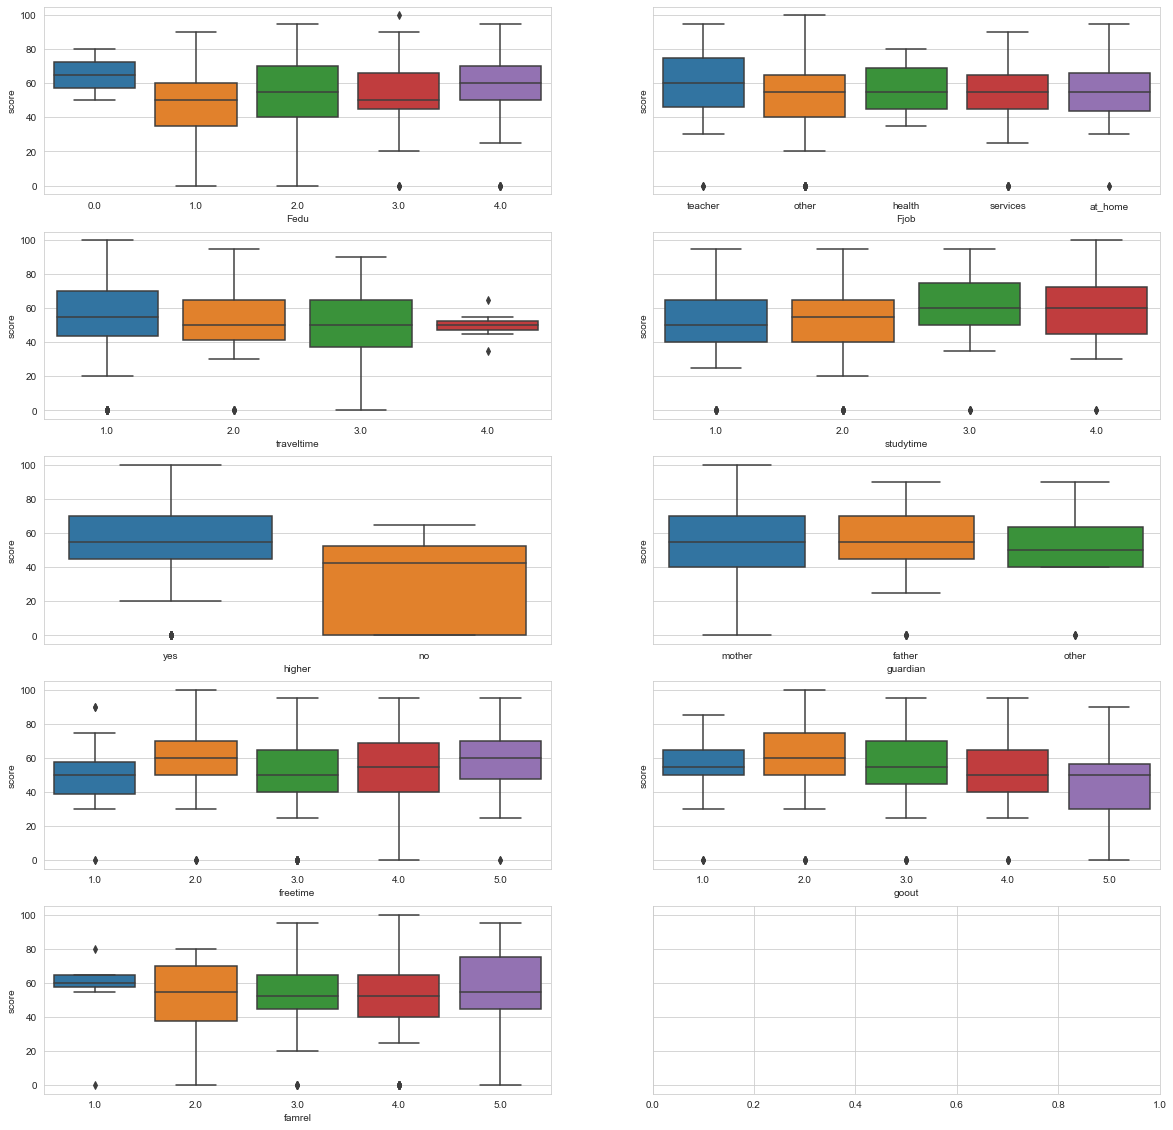

In [53]:
# Признаки 'Fjob', 'freetime', 'traveltime', 'famrel', 'higher', 'studytime', 'goout', 'Fedu', 'guardian'
# не удовлетворяют критериям приенимости теста стьюдента, поэтому отберем их по боксплотам
fig, axes = plt.subplots(
    int(np.ceil(len(not_tested_features) / 2)), 2, figsize=(20, 20), sharey=True)
for i in range(len(not_tested_features)):
    sns.boxplot(x=not_tested_features[i], y='score', data=stud, ax=axes[int(i / 2), i % 2])

In [54]:
# По приведенным боксплотам я бы остававил произнаки higher, Fedu. 
# Но так как Fedu коррелирует с Medu - его убираем.
impotant_features = impotant_features + ['higher']

In [55]:
# Формируем результирующий набор и удаляем возможные повторы строк
stud_math = stud[num_features + impotant_features + ['score_ival']].drop_duplicates()
stud_math.head(10)

,age,absences,score,Mjob,failures,sex,Medu,address,schoolsup,higher,score_ival
0,18,6.0,30.0,at_home,0.0,F,4.0,U,yes,yes,2
1,17,4.0,30.0,at_home,0.0,F,1.0,U,no,yes,2
2,15,10.0,50.0,at_home,3.0,F,1.0,U,yes,yes,3
3,15,2.0,75.0,health,0.0,F,4.0,U,no,yes,4
4,16,4.0,50.0,other,0.0,F,3.0,U,no,yes,3
5,16,10.0,75.0,services,0.0,M,4.0,U,no,yes,4
6,16,0.0,55.0,other,0.0,M,2.0,U,no,yes,3
7,17,6.0,30.0,other,0.0,F,4.0,U,yes,yes,2
8,15,0.0,95.0,services,0.0,M,3.0,U,no,yes,5
9,15,0.0,75.0,other,0.0,M,3.0,U,no,yes,4


In [56]:
# О результирующем датасете
stud_math.info()
display(stud_math.describe(include=np.number))
display(stud_math.describe(include=np.object))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 394
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         365 non-null    int64  
 1   absences    365 non-null    float64
 2   score       365 non-null    float64
 3   Mjob        365 non-null    object 
 4   failures    365 non-null    float64
 5   sex         365 non-null    object 
 6   Medu        365 non-null    float64
 7   address     365 non-null    object 
 8   schoolsup   365 non-null    object 
 9   higher      365 non-null    object 
 10  score_ival  365 non-null    int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 34.2+ KB


,age,absences,score,failures,Medu,score_ival
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,16.660274,5.158904,51.876712,0.301370,2.786301,3.221918
std,1.262165,5.899521,23.016922,0.704868,1.101113,1.065215
min,15.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,16.000000,0.000000,40.000000,0.000000,2.000000,3.000000
50%,17.000000,4.000000,55.000000,0.000000,3.000000,3.000000
75%,18.000000,8.000000,70.000000,0.000000,4.000000,4.000000
max,22.000000,30.000000,100.000000,3.000000,4.000000,5.000000


,Mjob,sex,address,schoolsup,higher
count,365,365,365,365,365
unique,5,2,2,2,2
top,other,F,U,no,yes
freq,136,193,287,319,349


## Выводы

В результате EDA для анализа влияния параметров ученика на его оценку по экзамену по математике были получены слкдующие выводы:

1 - Выбросы обнаружены в столбцах: absences, age, famrel и Fedu. Причем в absences их достаточно много. Строки с выбросами удалены.

 2 - В данных достаточно много пропусков. Если записи с пропусками удалить, может быть потеряна важная информация. Так как пропуски в данных можно считать случайными, они заменены на медиану для числовых признаков и моду для номинативных. Чтобы не потерять информацию о пропусках введены дополнительные признаки с суффиксом _nan, где 0 - пропуск в соответствующем столбце и 1 - иначе. Так как заменять их для номинативных переменных на значения статистик считаю неправильным, думаю необходимо воспользоваться методами ML для их заполнения.

3 - Обнаружена незначительная корреляция между параметрами age и absences (это логично, если предположить, что чем старше ученик,
тем у него больше соблазнов прогуливать занятия). Есть средняя корреляци я между признаками Fedu и Medu, что можно объяснить тем, что
скорее всего в большинстве семей уровень образования родителей относительно близок по уровню.

4 - С помощью теста Стьюдента с поправкой на множественную проверку гипотез Бонферони выявлены важные параметры для построения модели.
Это: 

In [57]:
print(impotant_features)

['Mjob', 'failures', 'sex', 'Medu', 'address', 'schoolsup', 'higher']


Такой способ отбора параметров не учитывает нелинейных зависимостей и зависимостей от комбинаций признаков, 
но для данного набора является приемлемой.

## P.S. Попробуем применить модель классификации к набору

In [58]:
from sklearn import model_selection, linear_model, metrics, pipeline, preprocessing, svm

In [59]:
import sklearn
print('sklearn version', sklearn.__version__)

sklearn version 0.24.1


In [60]:
stud_math

,age,absences,score,Mjob,failures,sex,Medu,address,schoolsup,higher,score_ival
0,18,6.0,30.0,at_home,0.0,F,4.0,U,yes,yes,2
1,17,4.0,30.0,at_home,0.0,F,1.0,U,no,yes,2
2,15,10.0,50.0,at_home,3.0,F,1.0,U,yes,yes,3
3,15,2.0,75.0,health,0.0,F,4.0,U,no,yes,4
4,16,4.0,50.0,other,0.0,F,3.0,U,no,yes,3
...,...,...,...,...,...,...,...,...,...,...,...
389,18,0.0,0.0,other,1.0,F,1.0,U,no,yes,1
391,17,3.0,80.0,services,0.0,M,3.0,U,no,yes,5
392,21,3.0,35.0,other,3.0,M,1.0,R,no,yes,2
393,18,0.0,50.0,services,0.0,M,3.0,R,no,yes,3


In [61]:
stud_math_model = stud_math.copy()

if 'school' in stud_math.columns:
    stud_math_model['school'] = stud_model['school'].map(
        lambda x: 1 if x == 'GP' else 0 if x == 'MS' else x)
if 'sex' in stud_math.columns:
    stud_math_model['sex'] = stud_model['sex'].map(
        lambda x: 1 if x == 'M' else 0 if x == 'F' else x)
if 'address' in stud_math.columns:
    stud_math_model['address'] = stud_model['address'].map(
        lambda x: 1 if x == 'U' else 0 if x == 'R' else x)
if 'famsize' in stud_math.columns:
    stud_math_model['famsize'] = stud_model['famsize'].map(
        lambda x: 1 if x == 'GT3' else 0 if x == 'LE3' else x)
if 'Pstatus' in stud_math.columns:
    stud_math_model['Pstatus'] = stud_model['Pstatus'].map(
        lambda x: 1 if x == 'A' else 0 if x == 'T' else x)

if 'schoolsup' in stud_math.columns:
    stud_math_model['schoolsup'] = stud_model['schoolsup'].map(
        lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
if 'famsup' in stud_math.columns:
    stud_math_model['famsup'] = stud_model['famsup'].map(
        lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
if 'paid' in stud_math.columns:
    stud_math_model['paid'] = stud_model['paid'].map(
        lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
if 'activities' in stud_math.columns:
    stud_math_model['activities'] = stud_model['activities'].map(
        lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
if 'nursery' in stud_math.columns:
    stud_math_model['nursery'] = stud_model['nursery'].map(
        lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
if 'higher' in stud_math.columns:
    stud_math_model['higher'] = stud_model['higher'].map(
        lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
if 'internet' in stud_math.columns:
    stud_math_model['internet'] = stud_model['internet'].map(
        lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)
if 'romantic' in stud_math.columns:
    stud_math_model['romantic'] = stud_model['romantic'].map(
        lambda x: 1 if x == 'yes' else 0 if x == 'no' else x)

stud_math_model = pd.concat([stud_math_model, pd.get_dummies(
    stud_math_model[['Mjob', 'failures', 'Medu']].astype('category'), dummy_na=False)], axis=1)
stud_math_model['age'] = preprocessing.StandardScaler(
).fit_transform(stud_math_model[['age']])
stud_math_model['absences'] = preprocessing.StandardScaler(
).fit_transform(stud_math_model[['absences']])
stud_math_model.drop(['Mjob', 'failures', 'Medu'], axis=1, inplace=True)

In [62]:
stud_math_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 394
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            365 non-null    float64
 1   absences       365 non-null    float64
 2   score          365 non-null    float64
 3   sex            365 non-null    float64
 4   address        365 non-null    float64
 5   schoolsup      365 non-null    float64
 6   higher         365 non-null    float64
 7   score_ival     365 non-null    int64  
 8   Mjob_at_home   365 non-null    uint8  
 9   Mjob_health    365 non-null    uint8  
 10  Mjob_other     365 non-null    uint8  
 11  Mjob_services  365 non-null    uint8  
 12  Mjob_teacher   365 non-null    uint8  
 13  failures_0.0   365 non-null    uint8  
 14  failures_1.0   365 non-null    uint8  
 15  failures_2.0   365 non-null    uint8  
 16  failures_3.0   365 non-null    uint8  
 17  Medu_0.0       365 non-null    uint8  
 18  Medu_1.0  

In [75]:
stud_math_model.dropna(inplace=True)
X = stud_math_model.drop(['score', 'score_ival'], axis=1)
y = stud_math_model['score_ival'] 
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [76]:
model = linear_model.LogisticRegression(random_state=42, max_iter=1000)

In [77]:
_ = model.fit(X_train, y_train)

In [78]:
metrics.accuracy_score(y_test, model.predict(X_test), normalize=True)

0.4782608695652174

In [79]:
y_test.to_numpy()

array([4, 5, 4, 4, 3, 4, 3, 3, 1, 1, 1, 5, 4, 3, 1, 3, 2, 5, 3, 5, 4, 3,
       3, 4, 1, 2, 4, 3, 4, 5, 3, 3, 2, 2, 3, 4, 4, 4, 4, 4, 4, 5, 4, 4,
       4, 3, 3, 5, 4, 4, 3, 3, 4, 5, 3, 4, 4, 4, 3, 2, 3, 4, 4, 2, 4, 3,
       4, 3, 3, 4, 3, 2, 3, 3, 3, 3, 4, 2, 3, 3, 5, 3, 2, 4, 3, 4, 4, 3,
       3, 4, 4, 3])

In [80]:
model.predict(X_test)

array([3, 3, 4, 3, 4, 3, 3, 1, 1, 4, 1, 4, 3, 3, 1, 3, 3, 3, 3, 4, 4, 4,
       3, 3, 1, 3, 3, 3, 1, 3, 3, 4, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 4, 4,
       4, 3, 3, 4, 4, 3, 4, 3, 1, 3, 3, 1, 4, 4, 1, 3, 4, 1, 4, 4, 3, 3,
       3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 2, 4, 3, 4, 3, 4, 3, 3,
       3, 3, 4, 3])

In [81]:
y_test.to_numpy() - model.predict(X_test)

array([ 1,  2,  0,  1, -1,  1,  0,  2,  0, -3,  0,  1,  1,  0,  0,  0, -1,
        2,  0,  1,  0, -1,  0,  1,  0, -1,  1,  0,  3,  2,  0, -1, -1, -1,
        0,  1,  0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  1,  0,  1, -1,
        0,  3,  2,  0,  3,  0,  0,  2, -1, -1,  3,  0, -2,  1,  0,  1,  0,
        0,  0,  0, -1, -1,  0,  0,  0,  1, -1,  0,  0,  3, -1, -1,  0,  0,
        0,  1,  0,  0,  1,  0,  0])

In [70]:
# Результат не очень хорош, но и исходный набор не очень - небольшой размер, много пропусков. 
# Возможно, другая модель даст лучшие результаты.